In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [3]:
#not used currently
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [4]:
#not used currently
def get_best_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if ("ablation" in filename) or ("encoding-scrambled-original" in filename):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                print(condition)
                if not condition in score_dict:
                    score_dict[condition] = {}
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(result, '\n\n')
                max_score, error = get_max_score(result)
                score_dict[condition]['score'] = max_score
                score_dict[condition]['error'] = error
    return score_dict

In [5]:
def get_last_scores_df(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    last_scores = []
    errors = []
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if ("ablation" in filename) or ("encoding-scrambled-original" in filename):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                if "-" in condition:
                    condition = condition.split("-")[1]
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(result, '\n\n')
                last_score, error = last_score, error = result[-1][0], result[-1][1]
                conditions.append(condition)
                last_scores.append(last_score)
                errors.append(error)
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': last_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=['original', 'nouns', 'nounsverbs', 'nounsverbsadj', 'functionwords', 'passageshuffle'])
    #df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [6]:
scores_df = get_last_scores_df('distilgpt2')

### Quick sanity check

In [7]:
scores_df

,score,error,condition
5,0.445486,0.141692,original
1,0.626163,0.161234,nouns
2,0.536390,0.125478,nounsverbs
3,0.598142,0.115482,nounsverbsadj
0,0.572999,0.072939,functionwords
4,0.773204,0.100471,passageshuffle


In [8]:
def bar_plot(model_identifier,get_last_scores_df):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(get_last_scores_df))
    scores = get_last_scores_df['score']
    errors = get_last_scores_df['error']
    conditions = get_last_scores_df['condition']
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=60)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    savename = 'fig/match-to-brain-ablation-{}.png'.format(model_identifier)
    plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

In [9]:
def main_plot(model_identifier):
    scores_df = get_last_scores_df(model_identifier)
    bar_plot(model_identifier,scores_df)

# Ready to plot!

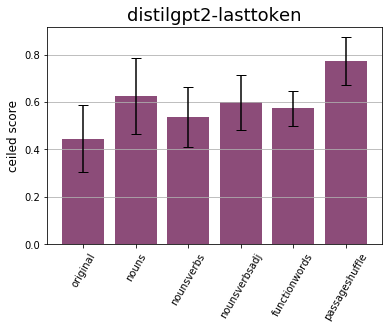

In [10]:
main_plot('distilgpt2')

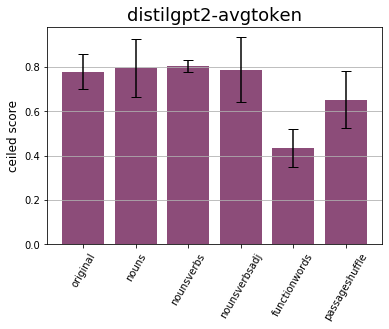

In [11]:
main_plot('distilgpt2-avgtoken')

# Loop to create subplots

In [12]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 4*nrows))
    #fig2.suptitle('Last-layer score across scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                print(model_list[counter])
                scores_df = get_last_scores_df(model_list[counter])
                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error-bar width
                       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=60)
                f2_ax[-1].set_title('{}'.format(model_list[counter]),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1
    fig2.savefig('fig/match-to-brain.png', bbox_inches='tight', dpi=240)

In [13]:
#get_subplots_loop(['glove','lm_1b','skip-thoughts','albert-xxlarge-v2','bert-large-uncased-whole-word-masking', 'xlnet-large-cased', 'distilgpt2', 'gpt2'])#,'distilbert-base-uncased'])

_____________________________
_____________________________
# Lineplot over layers

In [55]:
def get_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> list of scores across layers,
                                                    error --> list of associated errors}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if ("ablation" in filename) or ("encoding-scrambled-original" in filename):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                if "-" in condition:
                    condition = condition.split("-")[1]
                print(condition)
                if not condition in score_dict:
                    score_dict[condition] = {}
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(out['data'].layer) # sanity check which confirms order of layers is correct despite single-digit
                #names in e.g.g, gpt2, (i.e.: drop, encoder.h.0, encoder.h.1, ..., encoder.h.10, encoder.h.11)
                scores = [result[i][0] for i in range(len(result))]
                errors = [result[i][1] for i in range(len(result))]
                score_dict[condition]['score'] = scores
                score_dict[condition]['error'] = errors
    ordered_score_dict = reorder_df(score_dict)
    return ordered_score_dict

In [56]:
def reorder_df(dictionary):
    desired_order_list = ['original', 'nouns', 'nounsverbs', 'nounsverbsadj', 'functionwords', 'passageshuffle']
    reordered_dict = {k: dictionary[k] for k in desired_order_list}
    return reordered_dict

In [57]:
#distilgpt2_score_dict = get_score_dict('distilgpt2')

In [58]:
#print(distilgpt2_score_dict.keys())

In [59]:
#print(distilgpt2_score_dict['scrambled7'])

In [60]:
working_dir2 = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir2)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir2,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                shortened_names = ['.'.join(elm.split(".")[:-1]) for elm in layer_list if '.layer.' in elm]
                layer_list = [layer_list[0]] + shortened_names
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            #shorten layer names
            if model_identifier == 'lm_1b':
                layers = [layer.split('/')[1] for layer in layers]
            if 'albert' in model_identifier:
                layers = [re.sub('.albert_layer_groups.','.h.', layer) for layer in layers]
            return layers
            break

In [75]:
#get_all_layers('lm_1b')

In [76]:
def get_layerplot(model_identifier):
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
        line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    layers = get_all_layers(model_identifier)
    score_dict = get_score_dict(model_identifier)
    print(score_dict['original'].keys())
        
    fig, ax = plt.subplots()
    
    x = np.array(layers)
    counter = 0
    for key,value in score_dict.items():
        ax.plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
        counter += 1

    conditions = list(score_dict.keys())

    ax.set_title('Layer neural score evolution across conditions')
    ax.legend(conditions, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_label_text('ceiled score')
    plt.xticks(rotation= 90)

functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original
dict_keys(['score', 'error'])


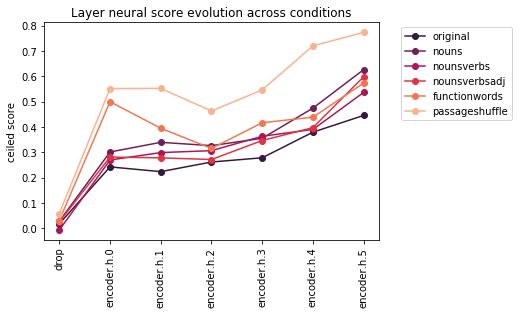

In [77]:
get_layerplot('distilgpt2')

In [78]:
#print(get_all_layers('gpt2'))

functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original
dict_keys(['score', 'error'])


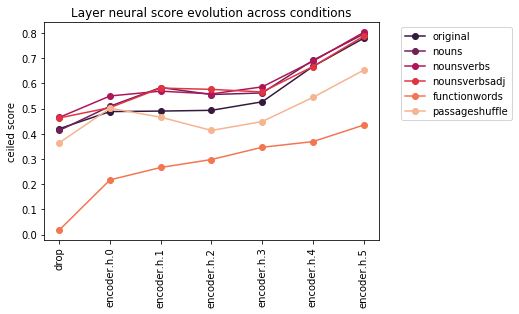

In [90]:
get_layerplot('distilgpt2-avgtoken')

In [80]:
#print(get_all_layers('albert-xxlarge-v2'))

In [81]:
#get_layerplot('albert-xxlarge-v2')

In [82]:
#print(get_all_layers('distilbert-base-uncased'))

In [83]:
#get_layerplot('distilbert-base-uncased')

In [84]:
#print(get_all_layers('bert-large-uncased-whole-word-masking'))

In [85]:
#get_layerplot('bert-large-uncased-whole-word-masking')

## Loop models into subplots

In [86]:
import math
from matplotlib.gridspec import GridSpec

def get_lineplots_loop(model_list,error_shading=True):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    #line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
        
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Score evolution of layers over scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                print(model_list[model_counter])
                layers = get_all_layers(model_list[model_counter])
                score_dict = get_score_dict(model_list[model_counter])
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                x = np.array(layers)
                for key,value in score_dict.items():
                    f2_ax[-1].plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
                    if error_shading==True:
                        f2_ax[-1].fill_between(x,np.array(score_dict[key]['score'])-np.array(score_dict[key]['error']), np.array(score_dict[key]['score'])+np.array(score_dict[key]['error']),facecolor=line_colors[counter],alpha=0.05)
                    counter += 1

                conditions = list(score_dict.keys())

                f2_ax[-1].set_title('{}'.format(model_list[model_counter]),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('ceiled score')
                plt.xticks(rotation= 90)
                #if model_counter == 0:
                    #f2_ax[-1].legend(conditions, loc='lower right')
                model_counter += 1
    #fig2.legend(conditions, loc='lower right')
    fig2.legend(conditions, bbox_to_anchor=(1.05, 1), loc='upper left')
    if error_shading==True:
        fig2.savefig('fig/match-to-brain-evolution-error-shading.png', bbox_inches='tight')
    else:
        fig2.savefig('fig/match-to-brain-evolution.png', bbox_inches='tight')

In [87]:
#get_lineplots_loop(['glove','lm_1b','skip-thoughts','albert-xxlarge-v2','bert-large-uncased-whole-word-masking', 'xlnet-large-cased', 'distilgpt2', 'gpt2'])
#bert-large-uncased-whole-word-masking lowpmi condition missing

distilgpt2
functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original
distilgpt2-avgtoken
functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original


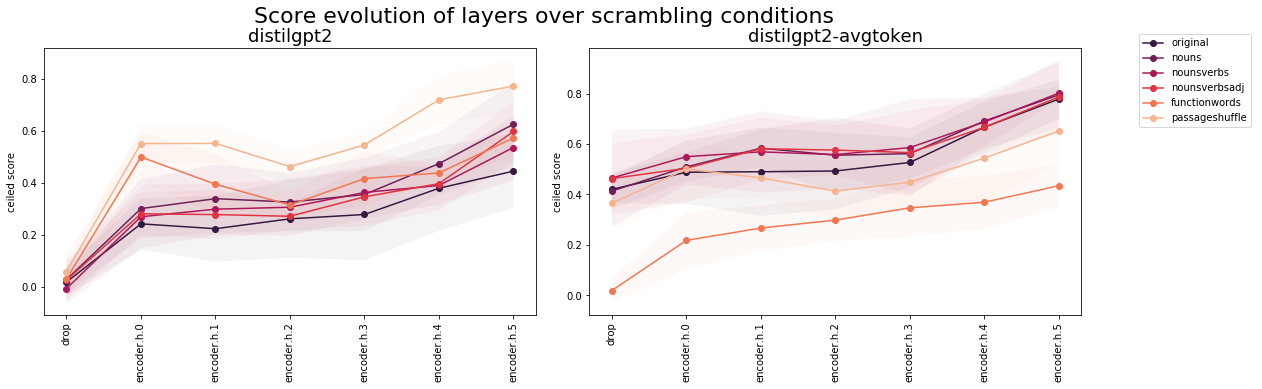

In [88]:
get_lineplots_loop(['distilgpt2', 'distilgpt2-avgtoken'],error_shading=True)

distilgpt2
functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original
distilgpt2-avgtoken
functionwords
nouns
nounsverbs
nounsverbsadj
passageshuffle
original


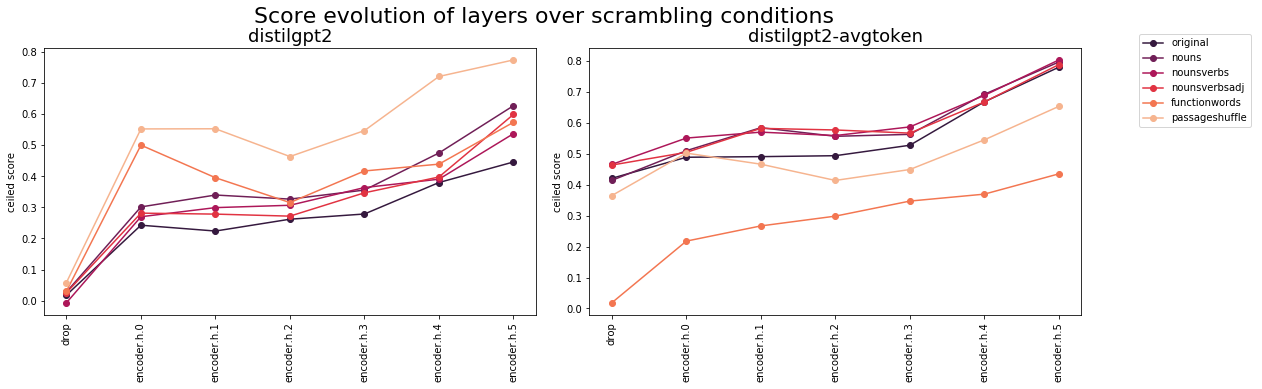

In [89]:
get_lineplots_loop(['distilgpt2', 'distilgpt2-avgtoken'],error_shading=False)